# Rapport Projet :

## Présentation du projet : 
Nous sommes trois sportifs et nous avions à cœur de lier notre projet de programmation avec le monde du sport. 
Pour explorer tous les enseignements du cours, nous avons cherché un sport dans lequel la prédiction statistique 
aurait pu répondre à des questions pratiques pour les joueurs et les entraîneurs. 
Comme deux d'entre nous pratiquent le handball, nous nous sommes donnés comme objectif d'élaborer un modèle de prédiction 
du poste d'un joueur de handball en fonction de ses caractéristiques morphologiques. 

Précisons ici que le handball se joue avec 1 gardien et 6 joueurs de champ, répartis en 4 postes :
Pivot, Ailiers (gauche et droit), Arrières (gauche et droit) et Demi-centre.  

![Composition Hand Star Game 2015 ](Images/Compo_France.jpg.webp)

In [ ]:
## Installations requises

! pip install bs4
! pip install selenium
! pip install webdriver-manager
! pip install seaborn
! pip install plotly
! pip install scikit-learn
! pip install nbformat


## Récupération des données
Pour mener à bien ce projet nous avons utilisé des données issues du site de la LNH (Ligue Nationale de Handball). La récupération de ces données a été faite par scrapping. 
Les données disponibles sur le site concernent les joueurs de la LNH inscrit dans un club de la ligue pour la saison 2023/2024. 
Parmi les informations auxquelles nous avons accédé, deux mesures nous intéressent particulièrement, le poids et la taille du joueur, ainsi que l'information sur le poste du joueur.
[Provenance des données](https://www.lnh.fr/liquimoly-starligue/stats/joueurs?seasons_id=36#stats)

In [4]:
## Récupération des données

from Scrapping_donnees_fonction import *

Scrapping(nom_df_match="DF_match_rapport.csv",nom_df_physique="DF_joueur_rapport.csv")

DF_match_rapport = pd.read_csv("DF_match_rapport.csv",index_col=0)
DF_joueur_rapport = pd.read_csv("DF_joueur_rapport.csv",index_col=0)

## /!\ Le scrapping des données peut prendre plus de 10 min !!

In [3]:
## /!\ A ne lancer que si vous n'avez pas lancer la cellule précédente et que vous préférez partir des données déjà sur Github plutôt que de relancer le scrapping des données
import pandas as pd

DF_match_rapport = pd.read_csv("Donnees/Donnees_match.csv",index_col=0)
DF_joueur_rapport = pd.read_csv("Donnees/Donnees_physique_joueurs.csv",index_col=0)

In [ ]:
# Affichage du DataFrame contenant les données de match
DF_match_rapport.head(10)

In [ ]:
# Affichage du DataFrame contenant les données des joueurs
DF_joueur_rapport.head(10)

In [4]:
## Nettoyage du DataFrame avec les données physiques des joueurs

from Nettoyage import *

cleaning(DF_joueur_rapport,nom_fichier="DF_joueur_rapport_nettoye.csv")

DF_joueur_rapport_nettoye = pd.read_csv("DF_joueur_rapport_nettoye.csv",index_col=0)


In [ ]:
# Affichage du DataFrame nettoyé
DF_joueur_rapport_nettoye.head(10)


| Page d'un joueur | Page des statistiques de match LNH              |
|-----------------------|-----------------------|
| ![Page d'un joueur](./Images/Screenshot_page_joueur_LNH.png) | ![Page des statistiques de match LNH](./Images/Screenshot_page_match_LNH.png)|

## Statistiques descriptives
A l'issu d'un travail de nettoyage et de présentation des données recueillies, une analyse descriptive s'est imposée pour comprendre la structure des données et s'assurer de l'intérêt de notre intuition initiale. 
Il apparaît en effet que les morphologies des joueurs sont plus proches les unes des autres que ce que nous estimions. Notre pratique du handball amateur permet à des physiques plus petits et plus légers d'avoir une place dans les équipes amateurs. Cependant, le niveau professionnel permet une sélection plus forte sur les physiques et ne sélectionne dans les équipes que des joueurs particulièrement athlétiques.
La disparité que nous présumions entre les postes n'est donc pas aussi marquée. Néanmoins une première projection du nuage des joueurs selon le poids et la taille permet d'identifier certains groupes. 

In [ ]:
## Statistiques descriptives des données morphologiques

from Stat_desc import *

# Représentation des joueurs sur le plan Taille, Poids
Visualisation_Taille_Poids(DF_joueur_rapport_nettoye)

In [ ]:
# Boite à moustache du poids selon le poste
Boxplot_poids(DF_joueur_rapport_nettoye)
afficher_violinplot(DF_joueur_rapport_nettoye,y='Poids')

# Boite à moustache de la taille selon le poste
Boxplot_taille(DF_joueur_rapport_nettoye)
afficher_violinplot(DF_joueur_rapport_nettoye,y='Taille')

In [ ]:
#Calcul moyenne et variance du poids et de la taille selon le poste
print(Moyenne_et_Std(DF_joueur_rapport_nettoye))

Plusieurs choses sont à remarquer sur ces graphiques de distribution.

Les pivots se démarquent notamment par le poids mais c'est aussi le poste avec les plus grandes variances. On peut donc estimer que le poste sera correctement prédit pour les joueurs dans la moyenne des pivots, mais la présence de certaines valeurs marginales limitera sûrement la précision. 

À l'inverse, les demi-centres semblent plus difficiles à prédire. Ceux-ci sont physiquement entre les ailiers et arrières et ont de plus une variance assez forte. Les diagrammes en violon permettent bien de représenter la disparité des physiques de demi-centre. 

Les ailiers se distinguent par une poids médian inférieur aux autres postes et un variance assez faible sur la taille. 

In [ ]:
# Nuage de points avec droites de régression linéaire
afficher_regression_par_poste(DF_joueur_rapport_nettoye)

On peut enfin reprendre le nuage de point et y ajouter les droites de régression linéaire pour mettre en évidence les tendances physiques selon les différents postes.
Les coefficients directeurs des droites semblent assez proches, excepté les ailiers pour lesquels la taille est moins corrélée au poids. Cette remarque est cohérente avec les objectifs du poste d'ailier : un grande explosivité, de la rapidité et de la mobilité sont indispensables pour ce poste qui intervient le plus souvent à la fin des actions de jeu.

Une dernière chose à souligner est le fait qu'en choisissant de regrouper les arrières gauches et droits sous la bannière "arrières", et idem pour les ailiers, notre base de données se retrouve déséquilibré. Il y a deux fois plus d'arrières et d'ailiers que de pivots et de demi-centres dans notre base de données

## Choix de modèle

Pour la partie prédictive de notre projet, nous avons rapidement constaté que l'enjeu était celui d'une catégorisation des individus. Il s’agit d’un problème de classification supervisée. Pour répondre à cet enjeu, nous avons testé trois modèles de classification : KNN, SVM, et Random Forest.

##### K-Nearest Neighbors (KNN)
Le KNN classe un joueur selon leur proximité dans l’espace taille-poids. Ce modèle est intuitif et non-paramétrique, mais se révèle sensible à la distribution des données. 
##### Le Support Vector Machine (SVM)
Le SVM repose sur la séparation des groupes à l’aide d’un hyperplan optimal qui maximise la marge entre les classes, ce qui le rend particulièrement adapté aux données bien séparées et pouvant nécessiter des transformations non linéaires grâce à des noyaux. 
##### Le Random Forest
Le Random Forest fonctionne grace à un grand nombre d’arbres de décision et permet une classification robuste en combinant plusieurs  paramètres. Ce modèle est performant sur des données déséquilibrées ce qui le rend particulièrement efficace pour notre problème puisque certains postes sont doublés (Arrières et Ailiers).

In [ ]:
## Choix des paramètres pour les modèles

from Choix_modele import *

parametre_KNN(DF_joueur_rapport_nettoye)

In [ ]:
print('Meilleurs paramètres pour SVM :')
parametres_SVM(DF_joueur_rapport_nettoye,metrique='f1_macro')

In [ ]:
print('Meilleurs paramètres pour Random Forest :')
parametres_Random_Forest(DF_joueur_rapport_nettoye,metrique='f1_macro')

## Choix de la métrique
L'enjeu principal pour rendre nos modèles de prédiction plus efficace est de choisir une métrique qui corresponde bien à la structure de nos données. En effet celles-ci sont déséquilibrées puisque les postes 'Ailier' et 'Arrière' rassemblent ceux qui jouent à gauche et à droite. 
Face à ce problème de surreprésentation de certains postes dans notre échantillon, nous avons considéré deux métriques : Balanced Accuracy et F1-Macro. Ces deux métriques de scoring permettent de donner un poids égal aux catégories sans tenir compte du déséquilibre des données.

La différence entre les deux mesures concerne principalement le poids donné au taux de vrai négatifs. Balanced Accuracy donne un score qui repose autant sur l'efficacité de prédiction des vrai positifs que sur la prédiction des vrais négatifs. À l'inverse, F1-Macro ne prend pas en compte le taux de vrai négatifs.

Il nous semble difficile de déterminer laquelle des deux métriques est la plus adaptée à notre problème, mais nous avons fini par trancher et avons choisi le F1-Macro. 



In [ ]:
## Evaluation des performances des différents modèles

from Evaluation import *

# Modèle KNN :
best_k = 5
Eval_modele_KNN(DF_joueur_rapport_nettoye,best_k)

# Modèle SVM :
best_parametres_SVM = {'kernel': 'rbf','C': 1, 'gamma': 10}
Eval_modele_SVM(DF_joueur_rapport_nettoye,best_parametres_SVM)

# Modèle Random Forest :
best_parametres_RF = {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Eval_modele_Random_Forest(DF_joueur_rapport_nettoye,best_parametres_RF)

## Analyse des résultats des prédictions 

Les trois modèles proposent donc une prédiction assez satisfaisante des postes d'Ailier et d'Arrière.
En effet ces deux postes sont surreprésentés dans notre échantillon ce qui rend la prédiction plus efficace. De plus, les ailiers, ainsi que les arrières dans une moindre mesure, ont des caractéristiques physiques assez différentes des autres postes. Les ailiers par exemple ont un poids nettement plus faibles que les autres joueurs à taille donnée.

Les pivots quant à eux sont convenablement prédits par le modèle Random Forest. On peut néanmoins remarquer que cette précision est peu satisfaisante par rapport à l'écart que nous avions remarqué pour les pivots sur le nuage de point. 

Enfin, les demi-centres sont les joueurs les moins bien prédits. Deux raison peuvent être données : la sous-représentation dans l'échantillon et la disparité des morphologies. 

Pour la prédiction finale sur l'ensemble des données, nous avons donc opté pour une classification via un modèle Random Forest !

In [ ]:
## Prédiction sur l'ensemble du DataSet

from Prediction import *


Prediction(DF_joueur_rapport_nettoye,type_modele='RF',nom_fichier='DF_joueur_rapport_predit.csv')

DF_joueur_rapport_predit = pd.read_csv("DF_joueur_rapport_predit.csv",index_col=0)

# Affichage du DataFrame avec les prédictions
DF_joueur_rapport_predit.head(10)

Après avoir effectué la prédiction sur l'ensemble de nos données, on obitent des résultats cohérents avec nos premières impressions.
Sur l'ensemble des données, plus de 190 joueurs sont prédits au poste auquel il joue actuellement, tandis qu'environ 120 joueurs sont prédits à un poste différent.
La prédiction est plus efficace efficace sur les ailiers et sur les arrières, avec environ 80% des arrières et ailiers prédits au poste auquel ils jouent.
Pour les pivots, on retrouve des résultats mitigés, avec environ la moitié qui sont prédits au poste de pivot, tandis qu'un tiers sont prédit au poste d'arrière.
Comme on le voyait, le modèle est très mauvais pour prédire le poste d'un demi-centre, seulement 8/53 demi-centres ont été prédit comme tel.


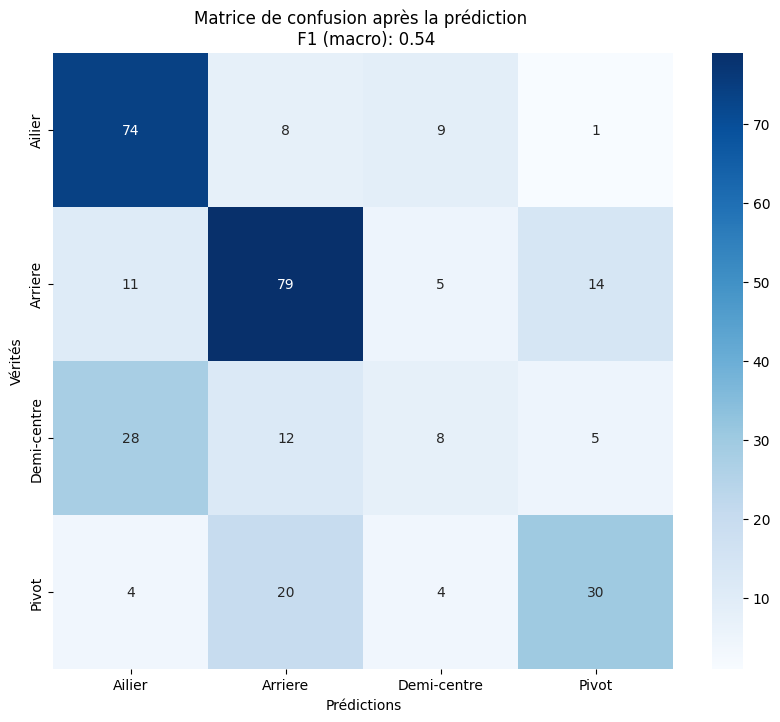

In [7]:
## Matrice de confusion après la prédiction
Rapport_prediction(DF_joueur_rapport_predit)

## Comparaison des performances
Nous utilisons dans cette partie le second DataFrame que nous avons obtenu depuis le site de la LNH. Il rassemble de nombreuses informations sur les **performances en match des joueurs**. Les principales informations que nous avons choisi d'étudier sont le nombre de buts et l'efficacité au tir (dans le jeu et sur penalty), le temps de jeu en minutes, ainsi que l'indice de performance LNH.

Nous joignons les deux DataFrames grace au Nom et au Prénom des joueurs afin notamment de lier le poste du joueur à ses performances en match. Notre objectif dans cette dernière partie est d'interroger les performances des joueurs selon leur poste en comparant entre le poste d'origine et le poste prédit par nos modèles.

In [ ]:
## Nettoyage du DataFrame contenant les données de match

# On travaille ici sur le deuxième DataFrame définit au début du Notebook

from fusion_csv import *

# Nettoyage
traitement(DF_match_rapport,nom_fichier="DF_match_rapport_nettoye.csv")

DF_match_rapport_nettoye = pd.read_csv("DF_match_rapport_nettoye.csv",index_col=0)

# Affichage du DataFrame nettoyé
DF_match_rapport_nettoye.head(10)

In [ ]:
# Jointure des 2 DataFrames

from fusion_csv import *

DF_joint_rapport = jointure_df(DF_joueur_rapport_predit,DF_match_rapport_nettoye,nom_fichier="DF_joint_rapport.csv")

# Affichage du DataFrame joint
DF_joint_rapport.head(10)

## Comparaison performance selon le poste prédit

Pour prolonger notre analyse et chercher à interpréter les erreurs de prédiction des modèles, nous cherchons à comparer les performances de joueurs avec les performances moyennes de leur poste réel et du poste auquel nous les avons prédits.

L'objectif est de savoir si un joueur qui n'a pas été correctement prédit par les modèles l'a été du fait d'une erreur de classification ou bien du fait que son poste de jeu réel ne correspond pas à ces caractéristiques physiques. 

##### Choix de l'indicateur
Pour cela, nous formons un indicateur agrégé de performance qui combine différentes mesures données par la table des performances de match. Un premier indicateur que nous avons tenté est celui d'une rapport simple entre le nombre de buts inscrits multiplié par 1+ l'efficacité au tir et divisé par le temps de jeu. Cet indicateur reflète bien la capacité d'un joueur a exploiter les situations de but par rapport au temps qu'il passe sur le terrain. 

À l'aide de cet indicateur, nous étudions deux quantités :
    - le ratio entre son score et la moyenne du score des joueurs jouant au même poste
    - le ratio entre son score et la moyenne du score des joueurs jouant au poste auquel le modèle le prédit
    
Si son score est proche de la moyenne de son poste prédit, on peut estimer que les caractérisques physiques du joueur correspondent légitimement à un autre poste que celui auquel il évolue actuellement.

In [ ]:
## Comparaison des performances

from Comparaison_perf import *


# traitement des données pour la comparaison
traitement_comparaison(DF_joint_rapport,nom_fichier='DF_joint_comp_rapport.csv')

DF_joint_comparaison_rapport = pd.read_csv('DF_joint_comp_rapport.csv',index_col=0)


# création du DataFrame avec les comparaisons
comparaison(DF_joint_comparaison_rapport,nom_fichier='DF_prediction_rapport.csv')

DF_prediction_rapport = pd.read_csv('DF_prediction_rapport.csv',index_col=0)


# Affichage du DataFrame avec les joueurs dont la prédiction diffère du poste actuel
DF_prediction_rapport

## Analyse des résultats

